In [43]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
from submission import Controller
from cobar_miniproject.cobar_fly import CobarFly
from cobar_miniproject import levels
from flygym import SingleFlySimulation, Camera
from tqdm import trange




timestep = 1e-4
debug = True
level = 4
seed = 0

fly = CobarFly(
    debug=debug,
    enable_vision=True,
    render_raw_vision=False,
)

if level <= 1:
    arena = levels[level](fly=fly, seed=seed)
else:
    arena = levels[level](fly=fly, timestep=timestep, seed=seed)

cam_params = {"pos": (0, 0, 80)}
timestep = 1e-4

cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name="camera_top_zoomout",
    targeted_fly_names=[fly.name],
    camera_parameters=cam_params,
    play_speed=0.2,
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
    arena=arena,
)

controller = Controller(timestep=timestep)

# run cpg simulation
obs, info = sim.reset()
obs_hist = []
info_hist = []

max_steps = 10000

for i in trange(max_steps):
    # Get observations
    obs, reward, terminated, truncated, info = sim.step(controller.get_actions(obs))
    sim.render()
    if controller.done_level(obs):
        # finish the path integration level
        break

    #if not obs["vision_updated"]:
    #if "vision" in obs:
    #    del obs["vision"]
    #if "raw_vision" in obs:
    #    del obs["raw_vision"]
    obs_hist.append(obs)
    info_hist.append(info)


    if hasattr(controller, "quit") and controller.quit:
        print("Simulation terminated by user.")
        break
    if hasattr(arena, "quit") and arena.quit:
        print("Target reached. Simulation terminated.")
        break

print(f"Available keys in obs: {list(obs.keys())}")


# Save video
save_path = Path("outputs") / f"level{level}_seed{seed}.mp4"
save_path.parent.mkdir(parents=True, exist_ok=True)
cam.save_video(save_path, stabilization_time=0)

  0%|          | 30/10000 [00:00<00:33, 299.10it/s]


--- Debug Info ---
Time: 0.0001 | Legs in stance: 0/6
Stance flags: [np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]
Estimated heading: 0.00°
True position: [0.01634914 0.00730949], True heading: 0.00°

--- Debug Info ---
Time: 0.0002 | Legs in stance: 0/6
Stance flags: [np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]
Estimated heading: 0.00°
True position: [0.01644516 0.0073068 ], True heading: 0.00°

--- Debug Info ---
Time: 0.0003 | Legs in stance: 0/6
Stance flags: [np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]
Estimated heading: 0.00°
True position: [0.01654996 0.00730389], True heading: 0.00°

--- Debug Info ---
Time: 0.0004 | Legs in stance: 0/6
Stance flags: [np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]
Estimated heading: 0.00°
True position: [0.01681441 0.00729863], True heading: 0.00°

--- Debug Info ---
Time: 0.0005 | Legs in stance: 0/6
Stance flags: [np.False_, np.False_, np.False_, np.False_, np

  1%|▏         | 134/10000 [00:00<00:22, 436.17it/s]

Leg 4 displacement during stance: [ 0.02258572 -0.02078426]
Estimated position: [-0.02258572  0.02078426] (delta_world=[-0.02258572  0.02078426])

--- Debug Info ---
Time: 0.0079 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.False_, np.False_]
Estimated heading: 0.00°
True position: [-0.00289127  0.00909068], True heading: 0.01°

--- Debug Info ---
Time: 0.0080 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.False_, np.False_]
Estimated heading: 0.00°
True position: [-0.00803163  0.00973639], True heading: 0.01°

--- Debug Info ---
Time: 0.0081 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.False_, np.False_]
Estimated heading: 0.00°
True position: [-0.01342566  0.01035448], True heading: 0.02°

--- Debug Info ---
Time: 0.0082 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.False_, np.False_]
Estimated heading: 0.00°
True position: [-0.01906421  0.01093

  2%|▎         | 250/10000 [00:00<00:20, 478.76it/s]


--- Debug Info ---
Time: 0.0189 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -7.83°
True position: [-0.25142983  0.09606482], True heading: 2.87°

--- Debug Info ---
Time: 0.0190 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -7.81°
True position: [-0.25106126  0.09657027], True heading: 2.89°
Leg 0 displacement during stance: [0.01061392 0.01776433]
Estimated position: [-0.60888135  0.09411602] (delta_world=[-0.01292229 -0.01616295])

--- Debug Info ---
Time: 0.0191 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -7.78°
True position: [-0.25072202  0.09703504], True heading: 2.91°

--- Debug Info ---
Time: 0.0192 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -7.76°
True position: [-0.25038117  0.09747

  3%|▎         | 345/10000 [00:00<00:22, 424.06it/s]


--- Debug Info ---
Time: 0.0273 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.False_, np.True_]
Estimated heading: -7.56°
True position: [-0.188092    0.15525068], True heading: 0.36°

--- Debug Info ---
Time: 0.0274 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.False_, np.True_]
Estimated heading: -7.65°
True position: [-0.1869068   0.15611067], True heading: 0.31°

--- Debug Info ---
Time: 0.0275 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.False_, np.True_]
Estimated heading: -7.74°
True position: [-0.18574892  0.15691166], True heading: 0.26°

--- Debug Info ---
Time: 0.0276 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.False_, np.True_]
Estimated heading: -7.84°
True position: [-0.18461892  0.15765144], True heading: 0.21°

--- Debug Info ---
Time: 0.0277 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.F

  4%|▍         | 400/10000 [00:00<00:22, 420.12it/s]


--- Debug Info ---
Time: 0.0377 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -11.74°
True position: [-0.0801729   0.15831657], True heading: -1.38°

--- Debug Info ---
Time: 0.0378 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -11.77°
True position: [-0.08038298  0.15968007], True heading: -1.32°

--- Debug Info ---
Time: 0.0379 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -11.80°
True position: [-0.08058131  0.16106696], True heading: -1.26°

--- Debug Info ---
Time: 0.0380 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -11.83°
True position: [-0.08076587  0.16247341], True heading: -1.19°

--- Debug Info ---
Time: 0.0381 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, n

  5%|▌         | 534/10000 [00:01<00:20, 465.16it/s]


--- Debug Info ---
Time: 0.0468 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -4.30°
True position: [-0.11760001  0.16040505], True heading: 3.00°

--- Debug Info ---
Time: 0.0469 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -4.13°
True position: [-0.11876012  0.16010389], True heading: 3.06°

--- Debug Info ---
Time: 0.0470 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -3.97°
True position: [-0.11990028  0.15990128], True heading: 3.12°

--- Debug Info ---
Time: 0.0471 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -3.80°
True position: [-0.1210129   0.15979189], True heading: 3.18°

--- Debug Info ---
Time: 0.0472 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.Fal

  6%|▌         | 600/10000 [00:01<00:21, 437.23it/s]


--- Debug Info ---
Time: 0.0580 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 21.90°
True position: [0.04575415 0.29582652], True heading: -3.57°

--- Debug Info ---
Time: 0.0581 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 22.29°
True position: [0.04720858 0.29405832], True heading: -3.62°

--- Debug Info ---
Time: 0.0582 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 22.69°
True position: [0.04864386 0.2922981 ], True heading: -3.67°

--- Debug Info ---
Time: 0.0583 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 23.08°
True position: [0.05006009 0.29054967], True heading: -3.71°

--- Debug Info ---
Time: 0.0584 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np

  7%|▋         | 727/10000 [00:01<00:18, 492.68it/s]


--- Debug Info ---
Time: 0.0668 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 34.84°
True position: [0.17654812 0.34750244], True heading: -1.02°

--- Debug Info ---
Time: 0.0669 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 35.03°
True position: [0.17746341 0.3490399 ], True heading: -1.02°

--- Debug Info ---
Time: 0.0670 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 35.22°
True position: [0.17835522 0.35048246], True heading: -1.02°

--- Debug Info ---
Time: 0.0671 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 35.42°
True position: [0.17922418 0.35182697], True heading: -1.02°

--- Debug Info ---
Time: 0.0672 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False

  8%|▊         | 829/10000 [00:01<00:19, 460.14it/s]


--- Debug Info ---
Time: 0.0773 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 40.01°
True position: [0.21877904 0.3987294 ], True heading: 1.60°

--- Debug Info ---
Time: 0.0774 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 40.03°
True position: [0.21990933 0.4017215 ], True heading: 1.49°

--- Debug Info ---
Time: 0.0775 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 40.05°
True position: [0.22112773 0.40471214], True heading: 1.37°

--- Debug Info ---
Time: 0.0776 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 40.07°
True position: [0.22241734 0.4076894 ], True heading: 1.25°

--- Debug Info ---
Time: 0.0777 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]


  9%|▉         | 933/10000 [00:02<00:19, 473.77it/s]


--- Debug Info ---
Time: 0.0868 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 38.95°
True position: [0.42486385 0.4547704 ], True heading: -6.24°

--- Debug Info ---
Time: 0.0869 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 38.90°
True position: [0.42636606 0.45358276], True heading: -6.27°
Leg 2 displacement during stance: [-0.02809215  0.00917114]
Estimated position: [0.39898258 1.76179516] (delta_world=[0.02763059 0.01047994])

--- Debug Info ---
Time: 0.0870 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: 38.85°
True position: [0.42787614 0.45244494], True heading: -6.31°

--- Debug Info ---
Time: 0.0871 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 38.80°
True position: [0.42937568 0.45135418], True h

 10%|█         | 1029/10000 [00:02<00:20, 442.67it/s]

Leg 3 displacement during stance: [0.03962624 0.00557673]
Estimated position: [0.5212667  2.38598707] (delta_world=[-0.02632846 -0.03013554])

--- Debug Info ---
Time: 0.0962 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 40.85°
True position: [0.5316687 0.5746141], True heading: -5.01°

--- Debug Info ---
Time: 0.0963 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 40.95°
True position: [0.53198063 0.57375383], True heading: -5.03°

--- Debug Info ---
Time: 0.0964 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 41.05°
True position: [0.5323421  0.57284844], True heading: -5.04°

--- Debug Info ---
Time: 0.0965 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 41.15°
True position: [0.53275347 0.5718998 ], True headi

 11%|█▏        | 1128/10000 [00:02<00:19, 456.29it/s]


--- Debug Info ---
Time: 0.1068 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 53.82°
True position: [0.5948209 0.6731791], True heading: -3.78°

--- Debug Info ---
Time: 0.1069 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 53.85°
True position: [0.5968288  0.67485374], True heading: -3.95°

--- Debug Info ---
Time: 0.1070 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 53.87°
True position: [0.59887004 0.67641675], True heading: -4.12°

--- Debug Info ---
Time: 0.1071 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 53.90°
True position: [0.6009337 0.6778626], True heading: -4.29°

--- Debug Info ---
Time: 0.1072 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
E

 12%|█▏        | 1222/10000 [00:02<00:19, 441.05it/s]

Leg 5 displacement during stance: [1.0132790e-05 1.3827622e-02]
Estimated position: [0.54501371 2.94614525] (delta_world=[ 0.01134855 -0.00790023])

--- Debug Info ---
Time: 0.1170 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: 55.20°
True position: [0.8154675 0.6130282], True heading: -8.65°

--- Debug Info ---
Time: 0.1171 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 55.13°
True position: [0.8183131 0.6141882], True heading: -8.60°

--- Debug Info ---
Time: 0.1172 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 55.05°
True position: [0.82113415 0.6154138 ], True heading: -8.56°
Leg 2 displacement during stance: [-0.01430607  0.00268599]
Estimated position: [0.55542007 2.95632296] (delta_world=[0.01040636 0.01017771])

--- Debug Info ---
Time: 0.1173 | Legs in stance: 3/6
S

 13%|█▎        | 1334/10000 [00:02<00:20, 432.60it/s]


--- Debug Info ---
Time: 0.1268 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 57.05°
True position: [0.96578526 0.6265083 ], True heading: -6.27°

--- Debug Info ---
Time: 0.1269 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 57.10°
True position: [0.9675784 0.6270378], True heading: -6.20°

--- Debug Info ---
Time: 0.1270 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 57.15°
True position: [0.9693872 0.6276724], True heading: -6.13°

--- Debug Info ---
Time: 0.1271 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 57.19°
True position: [0.9711354  0.62837857], True heading: -6.07°
Leg 0 displacement during stance: [-0.2664652  -0.05819207]
Estimated position: [0.81482361 3.06635544] (delta_world=[0.09464018 0.25579

 14%|█▍        | 1400/10000 [00:03<00:19, 435.52it/s]


--- Debug Info ---
Time: 0.1377 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.False_, np.True_]
Estimated heading: 68.51°
True position: [1.1184807  0.74765456], True heading: -12.64°

--- Debug Info ---
Time: 0.1378 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.False_, np.True_]
Estimated heading: 68.54°
True position: [1.1197898 0.7462214], True heading: -12.69°

--- Debug Info ---
Time: 0.1379 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.False_, np.True_]
Estimated heading: 68.57°
True position: [1.1210448  0.74478555], True heading: -12.73°

--- Debug Info ---
Time: 0.1380 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.False_, np.True_]
Estimated heading: 68.61°
True position: [1.1222475  0.74334586], True heading: -12.77°

--- Debug Info ---
Time: 0.1381 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.False_, 

 15%|█▌        | 1533/10000 [00:03<00:17, 488.07it/s]


--- Debug Info ---
Time: 0.1468 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 67.80°
True position: [1.361503  0.6858797], True heading: -14.05°

--- Debug Info ---
Time: 0.1469 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 67.83°
True position: [1.364477   0.68619967], True heading: -14.13°

--- Debug Info ---
Time: 0.1470 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 67.87°
True position: [1.3673736 0.6864631], True heading: -14.20°
Leg 3 displacement during stance: [-0.18360591 -0.03256524]
Estimated position: [0.79715817 3.60072493] (delta_world=[0.03843443 0.18246758])

--- Debug Info ---
Time: 0.1471 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: 68.05°
True position: [1.3702004 0.6866605], True hea

 16%|█▋        | 1633/10000 [00:03<00:18, 452.58it/s]


--- Debug Info ---
Time: 0.1564 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 58.94°
True position: [1.525469  0.5968674], True heading: -10.93°

--- Debug Info ---
Time: 0.1565 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 59.16°
True position: [1.5253305  0.59907323], True heading: -10.99°

--- Debug Info ---
Time: 0.1566 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 59.38°
True position: [1.5250854 0.6012892], True heading: -11.04°
Leg 0 displacement during stance: [ 0.00161648 -0.01209342]
Leg 4 displacement during stance: [-0.45295554  0.05595195]
Estimated position: [1.34935429 4.49663282] (delta_world=[0.13294735 0.18366446])

--- Debug Info ---
Time: 0.1567 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated head

 17%|█▋        | 1679/10000 [00:03<00:19, 437.04it/s]


--- Debug Info ---
Time: 0.1662 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 62.73°
True position: [1.6941183 0.702436 ], True heading: -19.42°

--- Debug Info ---
Time: 0.1663 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 62.78°
True position: [1.6948253 0.7006213], True heading: -19.45°

--- Debug Info ---
Time: 0.1664 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 62.84°
True position: [1.6955086 0.698787 ], True heading: -19.47°

--- Debug Info ---
Time: 0.1665 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 62.89°
True position: [1.6961722 0.6969321], True heading: -19.49°

--- Debug Info ---
Time: 0.1666 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
E

 18%|█▊        | 1800/10000 [00:03<00:17, 467.01it/s]


--- Debug Info ---
Time: 0.1735 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 65.75°
True position: [1.8886188 0.6100267], True heading: -20.04°

--- Debug Info ---
Time: 0.1736 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 65.95°
True position: [1.8940063 0.6087919], True heading: -20.11°

--- Debug Info ---
Time: 0.1737 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 66.16°
True position: [1.8993481 0.6074388], True heading: -20.19°
Leg 1 displacement during stance: [0.01044258 0.00327146]
Estimated position: [1.01213391 4.69645239] (delta_world=[-0.00119086 -0.01087805])

--- Debug Info ---
Time: 0.1738 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 66.36°
True position: [1.904627   0.60598177], True headi

 19%|█▉        | 1894/10000 [00:04<00:18, 448.56it/s]


--- Debug Info ---
Time: 0.1835 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 60.68°
True position: [2.1003041  0.45086217], True heading: -17.71°
Leg 2 displacement during stance: [ 0.03322649 -0.00056189]
Estimated position: [1.4520833  5.48551811] (delta_world=[-0.01659084 -0.02879339])

--- Debug Info ---
Time: 0.1836 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 61.02°
True position: [2.1014934  0.45335582], True heading: -17.79°

--- Debug Info ---
Time: 0.1837 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 61.36°
True position: [2.102606   0.45585966], True heading: -17.88°

--- Debug Info ---
Time: 0.1838 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 61.71°
True position: [2.1036456 0.4583687], True 

 20%|██        | 2001/10000 [00:04<00:19, 414.97it/s]

Leg 3 displacement during stance: [-0.00053334 -0.00877655]
Estimated position: [1.46606301 5.54172791] (delta_world=[-0.00757555  0.00446354])

--- Debug Info ---
Time: 0.1935 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 62.97°
True position: [2.311995   0.52962065], True heading: -26.90°

--- Debug Info ---
Time: 0.1936 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 62.90°
True position: [2.3122883 0.5278838], True heading: -26.95°

--- Debug Info ---
Time: 0.1937 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 62.82°
True position: [2.3125296 0.5261715], True heading: -27.00°

--- Debug Info ---
Time: 0.1938 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 62.74°
True position: [2.3127203 0.5244804], True hea

 21%|██        | 2065/10000 [00:04<00:16, 471.17it/s]


--- Debug Info ---
Time: 0.2034 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: 59.97°
True position: [2.5815966  0.29593968], True heading: -30.69°

--- Debug Info ---
Time: 0.2035 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 59.98°
True position: [2.5852392 0.2915959], True heading: -30.77°

--- Debug Info ---
Time: 0.2036 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 60.00°
True position: [2.5887904  0.28720993], True heading: -30.84°

--- Debug Info ---
Time: 0.2037 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 60.01°
True position: [2.5922475 0.2827913], True heading: -30.92°
Leg 2 displacement during stance: [-0.42050993 -0.18140668]
Estimated position: [1.52479513 6.50429526] (delta_world=[0.0552422

 22%|██▏       | 2159/10000 [00:04<00:17, 440.49it/s]


--- Debug Info ---
Time: 0.2115 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 47.04°
True position: [2.6928132  0.19250847], True heading: -26.31°

--- Debug Info ---
Time: 0.2116 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 47.36°
True position: [2.6940045  0.19486439], True heading: -26.38°

--- Debug Info ---
Time: 0.2117 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 47.68°
True position: [2.695216   0.19724827], True heading: -26.47°

--- Debug Info ---
Time: 0.2118 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 47.99°
True position: [2.6964738  0.19967967], True heading: -26.55°

--- Debug Info ---
Time: 0.2119 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.Tr

 23%|██▎       | 2259/10000 [00:05<00:17, 443.66it/s]


--- Debug Info ---
Time: 0.2202 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 53.41°
True position: [2.9151711  0.25616232], True heading: -35.52°

--- Debug Info ---
Time: 0.2203 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 53.38°
True position: [2.9159985 0.2539457], True heading: -35.64°

--- Debug Info ---
Time: 0.2204 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 53.34°
True position: [2.9167364  0.25174174], True heading: -35.76°

--- Debug Info ---
Time: 0.2205 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 53.31°
True position: [2.9173863  0.24955362], True heading: -35.88°

--- Debug Info ---
Time: 0.2206 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]


 24%|██▎       | 2356/10000 [00:05<00:17, 434.12it/s]


--- Debug Info ---
Time: 0.2303 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.False_, np.True_, np.False_]
Estimated heading: 46.93°
True position: [ 3.1120465  -0.01864236], True heading: -38.93°
Leg 1 displacement during stance: [-0.00317104  0.00967896]
Estimated position: [2.12286709 7.61914334] (delta_world=[ 0.00922461 -0.0043179 ])

--- Debug Info ---
Time: 0.2304 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: 46.78°
True position: [ 3.1156435  -0.02311895], True heading: -39.02°

--- Debug Info ---
Time: 0.2305 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: 46.62°
True position: [ 3.1191545  -0.02761849], True heading: -39.11°

--- Debug Info ---
Time: 0.2306 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: 46.46°
True position: [ 3.1225781  

 25%|██▍       | 2467/10000 [00:05<00:16, 443.55it/s]


--- Debug Info ---
Time: 0.2402 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 48.40°
True position: [ 3.2503302  -0.14759889], True heading: -36.18°

--- Debug Info ---
Time: 0.2403 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 48.35°
True position: [ 3.2523441  -0.14453977], True heading: -36.22°

--- Debug Info ---
Time: 0.2404 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 48.30°
True position: [ 3.2544346  -0.14149125], True heading: -36.27°
Leg 2 displacement during stance: [0.05320692 0.0048447 ]
Estimated position: [3.02445049 8.00576624] (delta_world=[-0.03179245 -0.04293818])

--- Debug Info ---
Time: 0.2405 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 48.28°
True position: [ 3.2565792  -0.13845561]

 26%|██▌       | 2563/10000 [00:05<00:16, 442.22it/s]


--- Debug Info ---
Time: 0.2503 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 47.57°
True position: [ 3.4489832  -0.18398188], True heading: -46.11°

--- Debug Info ---
Time: 0.2504 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 47.57°
True position: [ 3.4481258  -0.18529566], True heading: -46.14°
Leg 3 displacement during stance: [-0.02896619 -0.02236319]
Estimated position: [2.59013972 7.90081509] (delta_world=[0.00302369 0.03646929])

--- Debug Info ---
Time: 0.2505 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 47.59°
True position: [ 3.447242  -0.1866462], True heading: -46.16°

--- Debug Info ---
Time: 0.2506 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 47.61°
True position: [ 3.446338   -0.18803877], 

 27%|██▋       | 2667/10000 [00:05<00:17, 414.12it/s]


--- Debug Info ---
Time: 0.2602 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: 43.71°
True position: [ 3.651397 -0.568139], True heading: -48.93°

--- Debug Info ---
Time: 0.2603 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: 43.34°
True position: [ 3.652484   -0.57259536], True heading: -48.95°
Leg 3 displacement during stance: [0.00258708 0.00169694]
Estimated position: [2.92590503 8.89150555] (delta_world=[-0.00073588 -0.00300518])

--- Debug Info ---
Time: 0.2604 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.False_, np.True_, np.False_]
Estimated heading: 42.98°
True position: [ 3.6535008  -0.57693344], True heading: -48.95°

--- Debug Info ---
Time: 0.2605 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: 42.62°
True position: [ 3.6544523 -0.5812221

 28%|██▊       | 2773/10000 [00:06<00:16, 445.19it/s]

Leg 4 displacement during stance: [ 0.03137153 -0.02050722]
Estimated position: [3.37028199 8.88123017] (delta_world=[-0.03736    -0.00299155])

--- Debug Info ---
Time: 0.2701 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 37.75°
True position: [ 3.7957337  -0.56287634], True heading: -46.61°

--- Debug Info ---
Time: 0.2702 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 37.70°
True position: [ 3.7992468  -0.56231755], True heading: -46.72°

--- Debug Info ---
Time: 0.2703 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 37.65°
True position: [ 3.8027904 -0.5618545], True heading: -46.82°

--- Debug Info ---
Time: 0.2704 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 37.60°
True position: [ 3.8063622 -0.5614

 29%|██▊       | 2867/10000 [00:06<00:16, 423.59it/s]


--- Debug Info ---
Time: 0.2802 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 36.34°
True position: [ 3.8727593 -0.7093159], True heading: -55.31°

--- Debug Info ---
Time: 0.2803 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 36.38°
True position: [ 3.8717182 -0.7113002], True heading: -55.33°
Leg 1 displacement during stance: [-0.47654    -0.20575094]
Leg 5 displacement during stance: [-0.02285552 -0.41858393]
Estimated position: [3.35758014 9.08194028] (delta_world=[0.01736397 0.39936947])

--- Debug Info ---
Time: 0.2804 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: 36.17°
True position: [ 3.8709278 -0.7134502], True heading: -55.35°

--- Debug Info ---
Time: 0.2805 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.False_]
Estima

 30%|██▉       | 2965/10000 [00:06<00:16, 435.36it/s]


--- Debug Info ---
Time: 0.2909 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 25.30°
True position: [ 4.0291185 -1.1790884], True heading: -55.85°
Leg 2 displacement during stance: [-0.03494596  0.12383243]
Estimated position: [3.72991131 9.24879968] (delta_world=[ 0.08435601 -0.09715841])

--- Debug Info ---
Time: 0.2910 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 25.21°
True position: [ 4.028344 -1.180237], True heading: -55.74°

--- Debug Info ---
Time: 0.2911 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 25.16°
True position: [ 4.0276165 -1.1812834], True heading: -55.62°

--- Debug Info ---
Time: 0.2912 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 25.12°
True position: [ 4.0269423 -1.1822305], True 

 31%|███       | 3067/10000 [00:06<00:16, 422.35it/s]


--- Debug Info ---
Time: 0.3002 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 27.60°
True position: [ 4.2569656 -1.1362884], True heading: -57.81°

--- Debug Info ---
Time: 0.3003 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 27.57°
True position: [ 4.259682  -1.1380091], True heading: -57.93°
Leg 0 displacement during stance: [0.012483   0.02988005]
Estimated position: [4.22815149 9.21275457] (delta_world=[ 0.00275116 -0.03226567])

--- Debug Info ---
Time: 0.3004 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 27.55°
True position: [ 4.2622757 -1.1397862], True heading: -58.04°

--- Debug Info ---
Time: 0.3005 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 27.52°
True position: [ 4.2647843 -1.1416473], Tr

 32%|███▏      | 3173/10000 [00:07<00:15, 449.13it/s]


--- Debug Info ---
Time: 0.3100 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 24.75°
True position: [ 4.2606907 -1.3512645], True heading: -64.25°

--- Debug Info ---
Time: 0.3101 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 24.79°
True position: [ 4.2633495 -1.3559434], True heading: -64.25°

--- Debug Info ---
Time: 0.3102 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 24.84°
True position: [ 4.2661114 -1.36073  ], True heading: -64.25°
Leg 1 displacement during stance: [ 0.00313091 -0.00026059]
Estimated position: [4.5286992  9.80570541] (delta_world=[-0.00294992 -0.00108097])

--- Debug Info ---
Time: 0.3103 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 24.88°
True position: [ 4.268964  -1.3656163],

 32%|███▏      | 3219/10000 [00:07<00:15, 430.87it/s]


--- Debug Info ---
Time: 0.3195 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 13.77°
True position: [ 4.3174887 -1.7630628], True heading: -63.68°

--- Debug Info ---
Time: 0.3196 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 13.71°
True position: [ 4.317386  -1.7634956], True heading: -63.57°

--- Debug Info ---
Time: 0.3197 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 13.65°
True position: [ 4.3174276 -1.7638733], True heading: -63.46°

--- Debug Info ---
Time: 0.3198 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 13.59°
True position: [ 4.31762   -1.7641985], True heading: -63.35°

--- Debug Info ---
Time: 0.3199 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.

 33%|███▎      | 3326/10000 [00:07<00:14, 452.32it/s]


--- Debug Info ---
Time: 0.3268 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 19.15°
True position: [ 4.52747   -1.7340248], True heading: -65.44°

--- Debug Info ---
Time: 0.3269 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 19.19°
True position: [ 4.53063   -1.7353308], True heading: -65.55°
Leg 0 displacement during stance: [0.01477599 0.00093347]
Estimated position: [5.51140905 9.92247586] (delta_world=[-0.01364409 -0.00574806])

--- Debug Info ---
Time: 0.3270 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 19.23°
True position: [ 4.5337305 -1.7366776], True heading: -65.65°

--- Debug Info ---
Time: 0.3271 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 19.28°
True position: [ 4.536786  -1.7380877], Tr

 34%|███▍      | 3418/10000 [00:07<00:15, 415.94it/s]

Leg 5 displacement during stance: [0.01057839 0.04068559]
Estimated position: [5.60638371 9.97172003] (delta_world=[ 0.00164376 -0.04200617])

--- Debug Info ---
Time: 0.3368 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: 16.82°
True position: [ 4.5054836 -1.9085876], True heading: -73.12°
Leg 1 displacement during stance: [-0.02049518 -0.02228963]
Estimated position: [5.61959392 9.9989665 ] (delta_world=[0.01321022 0.02724647])

--- Debug Info ---
Time: 0.3369 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: 16.73°
True position: [ 4.5058527 -1.9121021], True heading: -73.13°

--- Debug Info ---
Time: 0.3370 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: 16.71°
True position: [ 4.506392  -1.9158149], True heading: -73.14°

--- Debug Info ---
Time: 0.3371 | Legs in stance: 4/6

 35%|███▌      | 3529/10000 [00:07<00:14, 452.72it/s]


--- Debug Info ---
Time: 0.3468 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 1.42°
True position: [ 4.5286856 -2.3629818], True heading: -73.69°

--- Debug Info ---
Time: 0.3469 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 1.22°
True position: [ 4.5278187 -2.3636062], True heading: -73.57°

--- Debug Info ---
Time: 0.3470 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 1.01°
True position: [ 4.5270395 -2.364177 ], True heading: -73.46°

--- Debug Info ---
Time: 0.3471 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 0.80°
True position: [ 4.5263577 -2.3646965], True heading: -73.34°

--- Debug Info ---
Time: 0.3472 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Es

 36%|███▌      | 3621/10000 [00:08<00:15, 417.51it/s]


--- Debug Info ---
Time: 0.3569 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 0.47°
True position: [ 4.782618  -2.4166615], True heading: -78.20°

--- Debug Info ---
Time: 0.3570 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 0.45°
True position: [ 4.783177 -2.419063], True heading: -78.34°

--- Debug Info ---
Time: 0.3571 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 0.42°
True position: [ 4.783581  -2.4214675], True heading: -78.48°

--- Debug Info ---
Time: 0.3572 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 0.40°
True position: [ 4.7838345 -2.423875 ], True heading: -78.63°
Leg 0 displacement during stance: [0.01438212 0.04112124]
Leg 2 displacement during stance: [ 0.03356564 -0.13249657]
Estimated po

 37%|███▋      | 3664/10000 [00:08<00:19, 332.08it/s]


--- Debug Info ---
Time: 0.3661 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -10.19°
True position: [ 4.6963334 -2.6225064], True heading: -83.46°
Leg 5 displacement during stance: [0.00701976 0.01002854]
Estimated position: [6.72501371 9.94084114] (delta_world=[-0.00873668 -0.00857432])

--- Debug Info ---
Time: 0.3662 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -10.55°
True position: [ 4.6978283 -2.6282077], True heading: -83.48°

--- Debug Info ---
Time: 0.3663 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -10.90°
True position: [ 4.6993513 -2.6339927], True heading: -83.50°

--- Debug Info ---
Time: 0.3664 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -11.26°
True position: [ 4.700896  -2.639855

 37%|███▋      | 3745/10000 [00:08<00:18, 341.43it/s]


--- Debug Info ---
Time: 0.3676 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: -11.99°
True position: [ 4.7172027 -2.7128162], True heading: -83.97°

--- Debug Info ---
Time: 0.3677 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: -12.16°
True position: [ 4.7180843 -2.7189727], True heading: -84.03°

--- Debug Info ---
Time: 0.3678 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: -12.33°
True position: [ 4.718876  -2.7250998], True heading: -84.09°

--- Debug Info ---
Time: 0.3679 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: -12.51°
True position: [ 4.7195787 -2.7311885], True heading: -84.15°

--- Debug Info ---
Time: 0.3680 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, 

 38%|███▊      | 3800/10000 [00:08<00:15, 393.23it/s]


--- Debug Info ---
Time: 0.3766 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -26.51°
True position: [ 4.660721  -2.9810245], True heading: -82.14°

--- Debug Info ---
Time: 0.3767 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -26.56°
True position: [ 4.663235  -2.9810226], True heading: -82.08°

--- Debug Info ---
Time: 0.3768 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -26.61°
True position: [ 4.6659026 -2.9810054], True heading: -82.02°

--- Debug Info ---
Time: 0.3769 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -26.66°
True position: [ 4.668714  -2.9809709], True heading: -81.97°

--- Debug Info ---
Time: 0.3770 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, 

 39%|███▉      | 3891/10000 [00:08<00:15, 390.15it/s]


--- Debug Info ---
Time: 0.3850 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -21.03°
True position: [ 4.8946414 -3.0874662], True heading: -89.05°

--- Debug Info ---
Time: 0.3851 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -21.06°
True position: [ 4.894308 -3.090046], True heading: -89.20°

--- Debug Info ---
Time: 0.3852 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -21.09°
True position: [ 4.8938527 -3.0925832], True heading: -89.34°

--- Debug Info ---
Time: 0.3853 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -21.12°
True position: [ 4.893278  -3.0950973], True heading: -89.49°

--- Debug Info ---
Time: 0.3854 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, n

 40%|████      | 4001/10000 [00:09<00:14, 404.85it/s]


--- Debug Info ---
Time: 0.3935 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -20.85°
True position: [ 4.765203  -3.2483692], True heading: -93.31°

--- Debug Info ---
Time: 0.3936 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -20.81°
True position: [ 4.764744  -3.2538078], True heading: -93.31°
Leg 1 displacement during stance: [0.00378889 0.00183272]
Leg 5 displacement during stance: [0.0092268  0.01199895]
Estimated position: [7.66744444 9.61886355] (delta_world=[-0.00853609 -0.00416125])

--- Debug Info ---
Time: 0.3937 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -20.75°
True position: [ 4.764328  -3.2593405], True heading: -93.30°

--- Debug Info ---
Time: 0.3938 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estima

 41%|████      | 4067/10000 [00:09<00:14, 417.16it/s]


--- Debug Info ---
Time: 0.4041 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -36.53°
True position: [ 4.636769  -3.6341374], True heading: -90.23°

--- Debug Info ---
Time: 0.4042 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -36.61°
True position: [ 4.638529  -3.6351204], True heading: -90.15°

--- Debug Info ---
Time: 0.4043 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -36.69°
True position: [ 4.6404376 -3.6361556], True heading: -90.08°

--- Debug Info ---
Time: 0.4044 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -36.76°
True position: [ 4.642491  -3.6372383], True heading: -90.01°

--- Debug Info ---
Time: 0.4045 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, 

 42%|████▏     | 4173/10000 [00:09<00:13, 430.19it/s]


--- Debug Info ---
Time: 0.4129 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -31.55°
True position: [ 4.8343296 -3.887171 ], True heading: -94.80°

--- Debug Info ---
Time: 0.4130 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -31.54°
True position: [ 4.8344173 -3.891076 ], True heading: -94.94°

--- Debug Info ---
Time: 0.4131 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -31.53°
True position: [ 4.8344088 -3.8949218], True heading: -95.08°

--- Debug Info ---
Time: 0.4132 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -31.52°
True position: [ 4.8343077 -3.8986974], True heading: -95.23°

--- Debug Info ---
Time: 0.4133 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, n

 43%|████▎     | 4267/10000 [00:09<00:13, 418.07it/s]

Leg 1 displacement during stance: [-0.00151414 -0.00364196]
Leg 5 displacement during stance: [0.02799129 0.07684773]
Estimated position: [8.91694376 8.73149657] (delta_world=[-0.03202152 -0.02212811])

--- Debug Info ---
Time: 0.4202 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -35.47°
True position: [ 4.717054  -3.9962683], True heading: -99.67°

--- Debug Info ---
Time: 0.4203 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -35.33°
True position: [ 4.7142534 -3.9985952], True heading: -99.67°

--- Debug Info ---
Time: 0.4204 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -35.19°
True position: [ 4.711509  -4.0011215], True heading: -99.66°

--- Debug Info ---
Time: 0.4205 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Est

 44%|████▎     | 4362/10000 [00:10<00:13, 423.49it/s]


--- Debug Info ---
Time: 0.4301 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -41.18°
True position: [ 4.509782 -4.366311], True heading: -94.98°

--- Debug Info ---
Time: 0.4302 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -41.00°
True position: [ 4.5099096 -4.366548 ], True heading: -94.88°

--- Debug Info ---
Time: 0.4303 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -40.82°
True position: [ 4.510152  -4.3667655], True heading: -94.78°

--- Debug Info ---
Time: 0.4304 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -40.65°
True position: [ 4.510512 -4.366972], True heading: -94.68°

--- Debug Info ---
Time: 0.4305 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_

 45%|████▍     | 4460/10000 [00:10<00:12, 445.26it/s]


--- Debug Info ---
Time: 0.4401 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -33.74°
True position: [ 4.6862974 -4.6887407], True heading: -95.52°

--- Debug Info ---
Time: 0.4402 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -33.77°
True position: [ 4.686979  -4.6933455], True heading: -95.58°

--- Debug Info ---
Time: 0.4403 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -33.80°
True position: [ 4.6876063 -4.6978664], True heading: -95.65°
Leg 4 displacement during stance: [-0.00320709 -0.02643597]
Estimated position: [8.93417031 8.20119147] (delta_world=[0.01737758 0.02017834])

--- Debug Info ---
Time: 0.4404 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -33.82°
True position: [ 4.6881833 -4.7022905],

 45%|████▌     | 4548/10000 [00:10<00:13, 413.52it/s]


--- Debug Info ---
Time: 0.4476 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: -36.05°
True position: [ 4.604471 -4.801916], True heading: -100.68°

--- Debug Info ---
Time: 0.4477 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -36.24°
True position: [ 4.601177  -4.8031554], True heading: -100.69°
Leg 1 displacement during stance: [ 0.00396603 -0.00922275]
Estimated position: [9.49706083 8.12789272] (delta_world=[0.00222468 0.00978975])

--- Debug Info ---
Time: 0.4478 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -36.07°
True position: [ 4.597901 -4.804545], True heading: -100.69°

--- Debug Info ---
Time: 0.4479 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -35.83°
True position: [ 4.594633  -4.8060813], 

 46%|████▌     | 4601/10000 [00:10<00:13, 393.16it/s]


--- Debug Info ---
Time: 0.4576 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -31.89°
True position: [ 4.413285 -5.118399], True heading: -94.02°

--- Debug Info ---
Time: 0.4577 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -31.89°
True position: [ 4.4139075 -5.11867  ], True heading: -93.93°
Leg 3 displacement during stance: [-0.05094409 -0.09123147]
Estimated position: [9.21262002 8.2114847 ] (delta_world=[0.09141175 0.05061989])

--- Debug Info ---
Time: 0.4578 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -31.85°
True position: [ 4.4146056 -5.1188893], True heading: -93.85°

--- Debug Info ---
Time: 0.4579 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -31.80°
True position: [ 4.4153776 -5.1190777], True 

 47%|████▋     | 4726/10000 [00:10<00:11, 448.10it/s]


--- Debug Info ---
Time: 0.4668 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -28.28°
True position: [ 4.5451236 -5.4130816], True heading: -92.24°

--- Debug Info ---
Time: 0.4669 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -28.43°
True position: [ 4.5466065 -5.4187036], True heading: -92.23°

--- Debug Info ---
Time: 0.4670 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -28.57°
True position: [ 4.548082 -5.424263], True heading: -92.22°

--- Debug Info ---
Time: 0.4671 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -28.71°
True position: [ 4.5495467 -5.4297423], True heading: -92.22°
Leg 0 displacement during stance: [0.00419211 0.02143806]
Estimated position: [9.57346511 7.52208156] (delta_world=[-0.014

 48%|████▊     | 4816/10000 [00:11<00:12, 415.74it/s]


--- Debug Info ---
Time: 0.4751 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -52.26°
True position: [ 4.521697 -5.591409], True heading: -98.24°
Leg 1 displacement during stance: [-0.03194213  0.01636934]
Leg 5 displacement during stance: [ 0.01911592 -0.14909142]
Estimated position: [10.54952329  7.27248838] (delta_world=[0.05633983 0.03564743])

--- Debug Info ---
Time: 0.4752 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -52.16°
True position: [ 4.517919  -5.5918827], True heading: -98.25°

--- Debug Info ---
Time: 0.4753 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -51.96°
True position: [ 4.5141263 -5.5924587], True heading: -98.25°

--- Debug Info ---
Time: 0.4754 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Esti

 49%|████▉     | 4911/10000 [00:11<00:12, 419.88it/s]

Leg 3 displacement during stance: [-0.01416314 -0.04281646]
Estimated position: [10.11533659  7.50613736] (delta_world=[0.04207553 0.01623247])

--- Debug Info ---
Time: 0.4837 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -50.60°
True position: [ 4.325957 -5.887157], True heading: -92.10°

--- Debug Info ---
Time: 0.4838 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -50.62°
True position: [ 4.3261003 -5.889452 ], True heading: -91.96°

--- Debug Info ---
Time: 0.4839 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -50.63°
True position: [ 4.3262534 -5.8916745], True heading: -91.82°

--- Debug Info ---
Time: 0.4840 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -50.65°
True position: [ 4.3264117 -5.8938284], Tru

 50%|████▉     | 4954/10000 [00:11<00:11, 422.54it/s]


--- Debug Info ---
Time: 0.4931 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -37.98°
True position: [ 4.470507 -6.135081], True heading: -89.50°

--- Debug Info ---
Time: 0.4932 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -38.14°
True position: [ 4.472546 -6.140713], True heading: -89.49°

--- Debug Info ---
Time: 0.4933 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -38.29°
True position: [ 4.4746237 -6.146309 ], True heading: -89.48°
Leg 0 displacement during stance: [0.01022196 0.00392228]
Estimated position: [10.44430643  6.29304254] (delta_world=[-0.01044431  0.00328468])

--- Debug Info ---
Time: 0.4934 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -38.45°
True position: [ 4.476731  -6.151855

 51%|█████     | 5067/10000 [00:11<00:11, 431.48it/s]


--- Debug Info ---
Time: 0.5002 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -51.36°
True position: [ 4.547827  -6.3685308], True heading: -93.85°

--- Debug Info ---
Time: 0.5003 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -51.59°
True position: [ 4.5469337 -6.3690114], True heading: -93.94°

--- Debug Info ---
Time: 0.5004 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -51.82°
True position: [ 4.5459146 -6.3695035], True heading: -94.02°

--- Debug Info ---
Time: 0.5005 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -52.05°
True position: [ 4.544764 -6.370011], True heading: -94.10°

--- Debug Info ---
Time: 0.5006 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.Tru

 52%|█████▏    | 5158/10000 [00:11<00:11, 425.21it/s]

Leg 1 displacement during stance: [-0.0095754  0.030743 ]
Leg 3 displacement during stance: [ 0.00318384 -0.03429848]
Estimated position: [11.15966487  5.94190612] (delta_world=[ 0.0031572  -0.00184538])

--- Debug Info ---
Time: 0.5101 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -59.39°
True position: [ 4.3155637 -6.694704 ], True heading: -92.01°

--- Debug Info ---
Time: 0.5102 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -59.56°
True position: [ 4.314345 -6.699421], True heading: -91.90°

--- Debug Info ---
Time: 0.5103 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -59.72°
True position: [ 4.313187 -6.704109], True heading: -91.78°

--- Debug Info ---
Time: 0.5104 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated 

 53%|█████▎    | 5254/10000 [00:12<00:10, 440.25it/s]


--- Debug Info ---
Time: 0.5201 | Legs in stance: 5/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -62.90°
True position: [ 4.450573 -6.944646], True heading: -86.59°
Leg 4 displacement during stance: [ 0.03619218 -0.01584291]
Estimated position: [10.93389167  5.47628022] (delta_world=[-0.00237963  0.03943614])

--- Debug Info ---
Time: 0.5202 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -62.91°
True position: [ 4.452755 -6.950317], True heading: -86.62°

--- Debug Info ---
Time: 0.5203 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -62.91°
True position: [ 4.454981  -6.9560165], True heading: -86.65°

--- Debug Info ---
Time: 0.5204 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -62.92°
True position: [ 4.457248  -6.9617267]

 53%|█████▎    | 5344/10000 [00:12<00:10, 425.43it/s]

Leg 4 displacement during stance: [0.00271022 0.00208807]
Estimated position: [11.38250827  5.38454188] (delta_world=[-0.00284703  0.00189731])

--- Debug Info ---
Time: 0.5268 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -71.29°
True position: [ 4.5686855 -7.210151 ], True heading: -91.16°

--- Debug Info ---
Time: 0.5269 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -71.61°
True position: [ 4.568922  -7.2113028], True heading: -91.26°

--- Debug Info ---
Time: 0.5270 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -71.92°
True position: [ 4.569094 -7.212381], True heading: -91.36°

--- Debug Info ---
Time: 0.5271 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -72.23°
True position: [ 4.5691915 -7.2133923], Tru

 54%|█████▍    | 5400/10000 [00:12<00:10, 442.98it/s]

Leg 3 displacement during stance: [ 0.02001941 -0.01528388]
Estimated position: [11.83742683  4.78042638] (delta_world=[0.01354939 0.02123177])

--- Debug Info ---
Time: 0.5356 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -85.18°
True position: [ 4.3806067 -7.4453278], True heading: -92.12°

--- Debug Info ---
Time: 0.5357 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -85.17°
True position: [ 4.3785753 -7.4505424], True heading: -92.10°

--- Debug Info ---
Time: 0.5358 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -85.15°
True position: [ 4.3765483 -7.4557714], True heading: -92.09°

--- Debug Info ---
Time: 0.5359 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -85.14°
True position: [ 4.374524 -7.46101

 55%|█████▍    | 5492/10000 [00:12<00:10, 420.02it/s]


--- Debug Info ---
Time: 0.5433 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -92.00°
True position: [ 4.361768  -7.6687336], True heading: -86.46°

--- Debug Info ---
Time: 0.5434 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -92.30°
True position: [ 4.3643937 -7.6694546], True heading: -86.42°

--- Debug Info ---
Time: 0.5435 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -92.59°
True position: [ 4.3671427 -7.6701417], True heading: -86.37°

--- Debug Info ---
Time: 0.5436 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -92.88°
True position: [ 4.370007 -7.670796], True heading: -86.33°

--- Debug Info ---
Time: 0.5437 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.Tru

 56%|█████▌    | 5597/10000 [00:12<00:09, 461.26it/s]


--- Debug Info ---
Time: 0.5535 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -94.50°
True position: [ 4.5893035 -8.018502 ], True heading: -90.92°

--- Debug Info ---
Time: 0.5536 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -94.63°
True position: [ 4.589411 -8.020698], True heading: -91.05°

--- Debug Info ---
Time: 0.5537 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -94.77°
True position: [ 4.5895042 -8.022749 ], True heading: -91.18°
Leg 4 displacement during stance: [ 0.01003291 -0.00096583]
Estimated position: [11.16100632  3.65029469] (delta_world=[0.00181868 0.00991385])

--- Debug Info ---
Time: 0.5538 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -94.90°
True position: [ 4.5895815 -8.024653 ], Tru

 57%|█████▋    | 5689/10000 [00:13<00:10, 426.96it/s]


--- Debug Info ---
Time: 0.5641 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -106.65°
True position: [ 4.3942204 -8.330572 ], True heading: -93.41°
Leg 3 displacement during stance: [ 0.01002705 -0.02979243]
Leg 5 displacement during stance: [0.04882419 0.02375102]
Estimated position: [11.49747868  2.89524554] (delta_world=[0.01133867 0.0273208 ])

--- Debug Info ---
Time: 0.5642 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: -106.68°
True position: [ 4.3917108 -8.336309 ], True heading: -93.41°

--- Debug Info ---
Time: 0.5643 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: -106.71°
True position: [ 4.389214 -8.342064], True heading: -93.41°
Leg 2 displacement during stance: [-0.2615478   0.09451652]
Estimated position: [11.33118132  2.67234239] (delta_world=[-0.16629736 -

 58%|█████▊    | 5800/10000 [00:13<00:09, 447.06it/s]


--- Debug Info ---
Time: 0.5723 | Legs in stance: 2/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.False_]
Estimated heading: -104.36°
True position: [ 4.3918095 -8.544762 ], True heading: -86.78°

--- Debug Info ---
Time: 0.5724 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: -103.97°
True position: [ 4.3954906 -8.546237 ], True heading: -86.76°

--- Debug Info ---
Time: 0.5725 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: -103.58°
True position: [ 4.39914  -8.547868], True heading: -86.75°

--- Debug Info ---
Time: 0.5726 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: -103.19°
True position: [ 4.402746 -8.549663], True heading: -86.75°

--- Debug Info ---
Time: 0.5727 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, 

 58%|█████▊    | 5846/10000 [00:13<00:09, 431.52it/s]

Leg 4 displacement during stance: [ 0.01715872 -0.04076648]
Estimated position: [10.94795169  2.27171273] (delta_world=[0.04336882 0.0086875 ])

--- Debug Info ---
Time: 0.5802 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -101.50°
True position: [ 4.575533 -8.871486], True heading: -91.57°

--- Debug Info ---
Time: 0.5803 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -101.49°
True position: [ 4.5762486 -8.874629 ], True heading: -91.70°

--- Debug Info ---
Time: 0.5804 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -101.49°
True position: [ 4.576902 -8.877699], True heading: -91.83°

--- Debug Info ---
Time: 0.5805 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -101.48°
True position: [ 4.577492 -8.880679], Tr

 59%|█████▉    | 5934/10000 [00:13<00:10, 405.65it/s]


--- Debug Info ---
Time: 0.5891 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -99.09°
True position: [ 4.4212093 -9.038578 ], True heading: -95.80°

--- Debug Info ---
Time: 0.5892 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -99.03°
True position: [ 4.419349 -9.044281], True heading: -95.76°

--- Debug Info ---
Time: 0.5893 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -98.97°
True position: [ 4.417477 -9.050054], True heading: -95.73°

--- Debug Info ---
Time: 0.5894 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -98.91°
True position: [ 4.4155917 -9.05589  ], True heading: -95.70°

--- Debug Info ---
Time: 0.5895 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_,

 60%|██████    | 6029/10000 [00:13<00:09, 415.62it/s]


--- Debug Info ---
Time: 0.5986 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -84.65°
True position: [ 4.335794 -9.337463], True heading: -89.40°

--- Debug Info ---
Time: 0.5987 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -84.17°
True position: [ 4.338328 -9.337994], True heading: -89.35°

--- Debug Info ---
Time: 0.5988 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -83.68°
True position: [ 4.3409824 -9.338548 ], True heading: -89.29°

--- Debug Info ---
Time: 0.5989 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -83.20°
True position: [ 4.343751 -9.339127], True heading: -89.24°

--- Debug Info ---
Time: 0.5990 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]


 61%|██████▏   | 6125/10000 [00:14<00:08, 434.42it/s]


--- Debug Info ---
Time: 0.6068 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -75.54°
True position: [ 4.511859 -9.659308], True heading: -90.82°

--- Debug Info ---
Time: 0.6069 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -75.50°
True position: [ 4.513149 -9.663885], True heading: -90.90°

--- Debug Info ---
Time: 0.6070 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -75.45°
True position: [ 4.5143857 -9.668402 ], True heading: -90.98°
Leg 2 displacement during stance: [-0.01466703 -0.0283125 ]
Estimated position: [10.76963626  1.0597107 ] (delta_world=[ 0.0310908  -0.00707685])

--- Debug Info ---
Time: 0.6071 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -75.44°
True position: [ 4.5155597 -9.672843 ], Tru

 62%|██████▏   | 6213/10000 [00:14<00:09, 400.92it/s]


--- Debug Info ---
Time: 0.6165 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -77.17°
True position: [ 4.3750134 -9.839158 ], True heading: -96.18°

--- Debug Info ---
Time: 0.6166 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -77.15°
True position: [ 4.372793 -9.843991], True heading: -96.13°

--- Debug Info ---
Time: 0.6167 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -77.13°
True position: [ 4.370581 -9.848928], True heading: -96.08°

--- Debug Info ---
Time: 0.6168 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -77.11°
True position: [ 4.3683753 -9.853966 ], True heading: -96.03°

--- Debug Info ---
Time: 0.6169 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, 

 63%|██████▎   | 6326/10000 [00:14<00:08, 434.84it/s]


--- Debug Info ---
Time: 0.6246 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -81.42°
True position: [  4.25401  -10.145009], True heading: -90.39°

--- Debug Info ---
Time: 0.6247 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -81.18°
True position: [  4.254472 -10.145658], True heading: -90.31°

--- Debug Info ---
Time: 0.6248 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -80.94°
True position: [  4.2550282 -10.146291 ], True heading: -90.24°

--- Debug Info ---
Time: 0.6249 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -80.70°
True position: [  4.255685 -10.146914], True heading: -90.16°

--- Debug Info ---
Time: 0.6250 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np

 64%|██████▎   | 6370/10000 [00:14<00:08, 434.09it/s]

Leg 2 displacement during stance: [ 0.06914079 -0.02067864]
Estimated position: [10.89454886  0.09541016] (delta_world=[-0.00518528  0.07198033])

--- Debug Info ---
Time: 0.6327 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -69.23°
True position: [  4.4177976 -10.396081 ], True heading: -89.99°

--- Debug Info ---
Time: 0.6328 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: -69.17°
True position: [  4.4197693 -10.4016285], True heading: -90.00°

--- Debug Info ---
Time: 0.6329 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -69.11°
True position: [  4.421755 -10.407146], True heading: -90.02°

--- Debug Info ---
Time: 0.6330 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -69.04°
True position: [  4.423746 -1

 65%|██████▍   | 6467/10000 [00:15<00:08, 415.98it/s]


--- Debug Info ---
Time: 0.6402 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -84.31°
True position: [  4.44735  -10.581597], True heading: -96.13°

--- Debug Info ---
Time: 0.6403 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -84.49°
True position: [  4.444583 -10.581919], True heading: -96.18°

--- Debug Info ---
Time: 0.6404 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -84.67°
True position: [  4.441688 -10.582265], True heading: -96.22°

--- Debug Info ---
Time: 0.6405 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -84.85°
True position: [  4.4386706 -10.582635 ], True heading: -96.26°

--- Debug Info ---
Time: 0.6406 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np

 66%|██████▌   | 6562/10000 [00:15<00:08, 426.68it/s]


--- Debug Info ---
Time: 0.6505 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -86.19°
True position: [  4.2081485 -10.940952 ], True heading: -91.96°

--- Debug Info ---
Time: 0.6506 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -85.99°
True position: [  4.207698 -10.943167], True heading: -91.84°

--- Debug Info ---
Time: 0.6507 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -85.79°
True position: [  4.2072973 -10.94525  ], True heading: -91.71°

--- Debug Info ---
Time: 0.6508 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -85.59°
True position: [  4.206949 -10.9472  ], True heading: -91.58°

--- Debug Info ---
Time: 0.6509 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, 

 67%|██████▋   | 6667/10000 [00:15<00:08, 412.99it/s]


--- Debug Info ---
Time: 0.6602 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -74.89°
True position: [  4.376784 -11.180626], True heading: -89.42°

--- Debug Info ---
Time: 0.6603 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -74.97°
True position: [  4.3784533 -11.186483 ], True heading: -89.43°

--- Debug Info ---
Time: 0.6604 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -75.05°
True position: [  4.3801675 -11.192287 ], True heading: -89.44°

--- Debug Info ---
Time: 0.6605 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -75.13°
True position: [  4.3819175 -11.198024 ], True heading: -89.45°
Leg 2 displacement during stance: [ 0.01742268 -0.00864387]
Estimated position: [11.11647616 -1.15318927] (d

 68%|██████▊   | 6763/10000 [00:15<00:07, 425.81it/s]

Leg 1 displacement during stance: [0.00765067 0.00169754]
Estimated position: [11.55948041 -1.87252101] (delta_world=[-0.000874    0.00778785])

--- Debug Info ---
Time: 0.6704 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -96.11°
True position: [  4.3412175 -11.41722  ], True heading: -95.89°

--- Debug Info ---
Time: 0.6705 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -95.84°
True position: [  4.338295 -11.419783], True heading: -95.89°
Leg 3 displacement during stance: [0.00456297 0.02345043]
Estimated position: [11.53661045 -1.86561388] (delta_world=[-0.02286996  0.00690713])

--- Debug Info ---
Time: 0.6706 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: -95.79°
True position: [  4.3354607 -11.422489 ], True heading: -95.88°

--- Debug Info ---
Time: 0.6707 | Legs in s

 69%|██████▊   | 6867/10000 [00:15<00:07, 426.57it/s]


--- Debug Info ---
Time: 0.6802 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -90.32°
True position: [  4.1909494 -11.778043 ], True heading: -89.07°

--- Debug Info ---
Time: 0.6803 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -89.92°
True position: [  4.1915035 -11.778665 ], True heading: -89.00°

--- Debug Info ---
Time: 0.6804 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -89.52°
True position: [  4.192154 -11.779263], True heading: -88.93°

--- Debug Info ---
Time: 0.6805 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -89.11°
True position: [  4.192909 -11.779843], True heading: -88.87°

--- Debug Info ---
Time: 0.6806 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, 

 70%|██████▉   | 6963/10000 [00:16<00:06, 434.74it/s]


--- Debug Info ---
Time: 0.6901 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -80.40°
True position: [  4.4043593 -12.102481 ], True heading: -89.35°
Leg 0 displacement during stance: [0.00530255 0.03152168]
Leg 4 displacement during stance: [-0.0069451  -0.02610099]
Estimated position: [11.04761936 -2.22885989] (delta_world=[-0.00253829 -0.00125601])

--- Debug Info ---
Time: 0.6902 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -80.53°
True position: [  4.4058633 -12.106491 ], True heading: -89.42°

--- Debug Info ---
Time: 0.6903 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -80.66°
True position: [  4.407326 -12.11048 ], True heading: -89.49°

--- Debug Info ---
Time: 0.6904 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Est

 71%|███████   | 7063/10000 [00:16<00:06, 441.57it/s]

Leg 1 displacement during stance: [0.0306167  0.01300693]
Leg 5 displacement during stance: [ 0.06657696 -0.00210613]
Estimated position: [11.49064154 -2.96903141] (delta_world=[0.01049519 0.04776201])

--- Debug Info ---
Time: 0.7001 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: -108.79°
True position: [  4.2752604 -12.29551  ], True heading: -94.83°

--- Debug Info ---
Time: 0.7002 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.False_]
Estimated heading: -108.81°
True position: [  4.273641 -12.300715], True heading: -94.78°

--- Debug Info ---
Time: 0.7003 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -108.83°
True position: [  4.2720428 -12.306008 ], True heading: -94.74°

--- Debug Info ---
Time: 0.7004 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.T

 72%|███████▏  | 7151/10000 [00:16<00:06, 412.10it/s]


--- Debug Info ---
Time: 0.7079 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -118.93°
True position: [  4.1797757 -12.6053915], True heading: -89.69°

--- Debug Info ---
Time: 0.7080 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -119.17°
True position: [  4.1797895 -12.6064   ], True heading: -89.60°

--- Debug Info ---
Time: 0.7081 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -119.42°
True position: [  4.1798663 -12.607366 ], True heading: -89.52°

--- Debug Info ---
Time: 0.7082 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -119.67°
True position: [  4.180016 -12.608291], True heading: -89.44°

--- Debug Info ---
Time: 0.7083 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.T

 72%|███████▏  | 7200/10000 [00:16<00:06, 432.97it/s]

Estimated position: [11.12794161 -3.05668462] (delta_world=[-0.01286216  0.0266673 ])

--- Debug Info ---
Time: 0.7167 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -120.98°
True position: [  4.3578587 -12.84752  ], True heading: -88.59°

--- Debug Info ---
Time: 0.7168 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -120.93°
True position: [  4.3599644 -12.852307 ], True heading: -88.62°

--- Debug Info ---
Time: 0.7169 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -120.88°
True position: [  4.3620462 -12.857075 ], True heading: -88.65°

--- Debug Info ---
Time: 0.7170 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -120.82°
True position: [  4.3640933 -12.861805 ], True heading: -88.69°

--- Debug Info ---


 73%|███████▎  | 7293/10000 [00:16<00:06, 417.85it/s]

Leg 5 displacement during stance: [-0.4000107 -0.2276532]
Estimated position: [11.18417233 -3.5397042 ] (delta_world=[-0.00509141 -0.46022671])

--- Debug Info ---
Time: 0.7246 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -120.28°
True position: [  4.3429995 -13.014504 ], True heading: -95.09°

--- Debug Info ---
Time: 0.7247 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -120.55°
True position: [  4.340079  -13.0158615], True heading: -95.10°
Leg 2 displacement during stance: [-0.09560704 -0.08002046]
Estimated position: [11.20379995 -3.66282502] (delta_world=[ 0.01962762 -0.12312082])

--- Debug Info ---
Time: 0.7248 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -120.87°
True position: [  4.3372426 -13.017451 ], True heading: -95.10°
Leg 1 displacement during stance: [-0.5829

 74%|███████▍  | 7400/10000 [00:17<00:05, 447.12it/s]

Leg 1 displacement during stance: [0.01926598 0.02318025]
Estimated position: [10.78923255 -4.21951772] (delta_world=[-0.0065254   0.02942653])

--- Debug Info ---
Time: 0.7335 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -127.77°
True position: [  4.161494 -13.358016], True heading: -91.39°
Leg 3 displacement during stance: [-0.00145853 -0.02580953]
Estimated position: [10.80869629 -4.23653012] (delta_world=[ 0.01946374 -0.0170124 ])

--- Debug Info ---
Time: 0.7336 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: -127.92°
True position: [  4.161183 -13.360417], True heading: -91.27°

--- Debug Info ---
Time: 0.7337 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -128.07°
True position: [  4.1608977 -13.3627405], True heading: -91.14°

--- Debug Info ---
Time: 0.7338 | Legs in st

 75%|███████▍  | 7489/10000 [00:17<00:06, 397.57it/s]


--- Debug Info ---
Time: 0.7436 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -132.72°
True position: [  4.313496 -13.593264], True heading: -88.49°
Leg 4 displacement during stance: [ 0.02534398 -0.01575673]
Estimated position: [10.48144487 -4.27093623] (delta_world=[0.0287823  0.00788485])

--- Debug Info ---
Time: 0.7437 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -132.81°
True position: [  4.3151307 -13.598445 ], True heading: -88.51°
Leg 0 displacement during stance: [0.01530278 0.01094097]
Estimated position: [10.48384942 -4.25227885] (delta_world=[0.00240455 0.01865738])

--- Debug Info ---
Time: 0.7438 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -132.91°
True position: [  4.3167734 -13.603562 ], True heading: -88.52°

--- Debug Info ---
Time: 0.7439 | Legs in s

 76%|███████▌  | 7593/10000 [00:17<00:05, 445.74it/s]


--- Debug Info ---
Time: 0.7520 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -144.62°
True position: [  4.3029113 -13.786936 ], True heading: -94.92°

--- Debug Info ---
Time: 0.7521 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -144.76°
True position: [  4.300157 -13.787726], True heading: -94.95°

--- Debug Info ---
Time: 0.7522 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -144.89°
True position: [  4.2973795 -13.788567 ], True heading: -94.97°

--- Debug Info ---
Time: 0.7523 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -145.03°
True position: [  4.2945895 -13.7894535], True heading: -94.98°

--- Debug Info ---
Time: 0.7524 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.T

 77%|███████▋  | 7683/10000 [00:17<00:05, 414.60it/s]


--- Debug Info ---
Time: 0.7602 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -149.87°
True position: [  4.1440563 -14.106794 ], True heading: -93.65°

--- Debug Info ---
Time: 0.7603 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -150.02°
True position: [  4.1426053 -14.110209 ], True heading: -93.56°

--- Debug Info ---
Time: 0.7604 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -150.17°
True position: [  4.1412253 -14.113523 ], True heading: -93.45°

--- Debug Info ---
Time: 0.7605 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -150.31°
True position: [  4.139915 -14.116731], True heading: -93.35°

--- Debug Info ---
Time: 0.7606 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_,

 78%|███████▊  | 7776/10000 [00:18<00:05, 435.91it/s]


--- Debug Info ---
Time: 0.7699 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -141.40°
True position: [  4.2770953 -14.286313 ], True heading: -89.01°
Leg 0 displacement during stance: [ 0.0091548  -0.00776541]
Estimated position: [ 9.43789216 -4.89554101] (delta_world=[ 0.01199917 -0.00036315])

--- Debug Info ---
Time: 0.7700 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -141.43°
True position: [  4.278413  -14.2915945], True heading: -89.07°

--- Debug Info ---
Time: 0.7701 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -141.45°
True position: [  4.2797127 -14.29693  ], True heading: -89.14°

--- Debug Info ---
Time: 0.7702 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: -141.48°
True position: [  4.

 78%|███████▊  | 7820/10000 [00:18<00:05, 399.07it/s]


--- Debug Info ---
Time: 0.7790 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -144.97°
True position: [  4.302723 -14.561194], True heading: -95.30°

--- Debug Info ---
Time: 0.7791 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -145.00°
True position: [  4.3006167 -14.561828 ], True heading: -95.34°

--- Debug Info ---
Time: 0.7792 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -145.03°
True position: [  4.2984114 -14.562513 ], True heading: -95.39°

--- Debug Info ---
Time: 0.7793 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -145.07°
True position: [  4.296111  -14.5632515], True heading: -95.43°

--- Debug Info ---
Time: 0.7794 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.T

 79%|███████▉  | 7928/10000 [00:18<00:04, 437.99it/s]


--- Debug Info ---
Time: 0.7868 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -145.95°
True position: [  4.132794 -14.844682], True heading: -94.54°
Leg 3 displacement during stance: [ 0.00729537 -0.02753383]
Estimated position: [ 9.21200632 -5.27457353] (delta_world=[ 0.02146411 -0.01872501])

--- Debug Info ---
Time: 0.7869 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.False_, np.False_, np.True_, np.True_]
Estimated heading: -145.94°
True position: [  4.130784 -14.848695], True heading: -94.50°

--- Debug Info ---
Time: 0.7870 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -145.93°
True position: [  4.1288075 -14.85268  ], True heading: -94.45°

--- Debug Info ---
Time: 0.7871 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -145.92°
True position: [  4.126868 -1

 80%|████████  | 8018/10000 [00:18<00:04, 423.90it/s]


--- Debug Info ---
Time: 0.7970 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -140.58°
True position: [  4.2160587 -15.053417 ], True heading: -88.70°

--- Debug Info ---
Time: 0.7971 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -140.60°
True position: [  4.21748  -15.058342], True heading: -88.75°

--- Debug Info ---
Time: 0.7972 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -140.61°
True position: [  4.218909 -15.063358], True heading: -88.80°

--- Debug Info ---
Time: 0.7973 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -140.63°
True position: [  4.22035 -15.06846], True heading: -88.84°

--- Debug Info ---
Time: 0.7974 | Legs in stance: 5/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, n

 81%|████████  | 8122/10000 [00:18<00:04, 442.95it/s]


--- Debug Info ---
Time: 0.8068 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -153.01°
True position: [  4.2716074 -15.353409 ], True heading: -95.39°

--- Debug Info ---
Time: 0.8069 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -153.19°
True position: [  4.2692685 -15.35389  ], True heading: -95.42°

--- Debug Info ---
Time: 0.8070 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -153.36°
True position: [  4.2668366 -15.354403 ], True heading: -95.45°

--- Debug Info ---
Time: 0.8071 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -153.54°
True position: [  4.2643156 -15.354943 ], True heading: -95.48°

--- Debug Info ---
Time: 0.8072 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np

 82%|████████▏ | 8212/10000 [00:19<00:04, 412.88it/s]


--- Debug Info ---
Time: 0.8167 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -155.35°
True position: [  4.067365 -15.689825], True heading: -92.55°

--- Debug Info ---
Time: 0.8168 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -155.12°
True position: [  4.066398 -15.692257], True heading: -92.43°

--- Debug Info ---
Time: 0.8169 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -154.89°
True position: [  4.0654793 -15.694573 ], True heading: -92.30°

--- Debug Info ---
Time: 0.8170 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -154.66°
True position: [  4.064613 -15.696764], True heading: -92.18°

--- Debug Info ---
Time: 0.8171 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_

 83%|████████▎ | 8323/10000 [00:19<00:03, 435.44it/s]

Leg 4 displacement during stance: [ 0.00691164 -0.00446963]
Estimated position: [ 7.32014941 -5.90833132] (delta_world=[0.00810665 0.00142499])

--- Debug Info ---
Time: 0.8268 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -137.14°
True position: [  4.2248726 -15.923147 ], True heading: -89.39°

--- Debug Info ---
Time: 0.8269 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -137.07°
True position: [  4.2264547 -15.928611 ], True heading: -89.41°

--- Debug Info ---
Time: 0.8270 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -136.99°
True position: [  4.2280607 -15.934028 ], True heading: -89.43°

--- Debug Info ---
Time: 0.8271 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -136.92°
True position: [  4.2296

 84%|████████▍ | 8411/10000 [00:19<00:03, 407.19it/s]


--- Debug Info ---
Time: 0.8355 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -148.12°
True position: [  4.2330837 -16.123772 ], True heading: -95.45°

--- Debug Info ---
Time: 0.8356 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -148.47°
True position: [  4.229877 -16.124147], True heading: -95.48°

--- Debug Info ---
Time: 0.8357 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -148.83°
True position: [  4.2266307 -16.124523 ], True heading: -95.50°

--- Debug Info ---
Time: 0.8358 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -149.18°
True position: [  4.2233562 -16.124895 ], True heading: -95.52°
Leg 1 displacement during stance: [-0.09417683 -0.00207937]
Estimated position: [ 7.25486832 -6.23164532] (delta_w

 85%|████████▌ | 8510/10000 [00:19<00:03, 409.55it/s]


--- Debug Info ---
Time: 0.8453 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -154.85°
True position: [  4.047465 -16.46539 ], True heading: -90.96°
Leg 1 displacement during stance: [0.00675219 0.0010854 ]
Estimated position: [ 7.35415778 -6.08875862] (delta_world=[0.005661  0.0038371])

--- Debug Info ---
Time: 0.8454 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -155.00°
True position: [  4.0473948 -16.46693  ], True heading: -90.84°

--- Debug Info ---
Time: 0.8455 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -155.16°
True position: [  4.04733 -16.4684 ], True heading: -90.72°

--- Debug Info ---
Time: 0.8456 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -155.32°
True position: [  4.047271 -16.469799],

 86%|████████▌ | 8552/10000 [00:20<00:03, 403.20it/s]


--- Debug Info ---
Time: 0.8528 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -155.85°
True position: [  4.1592546 -16.601595 ], True heading: -88.12°

--- Debug Info ---
Time: 0.8529 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -155.87°
True position: [  4.1607246 -16.606567 ], True heading: -88.16°

--- Debug Info ---
Time: 0.8530 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -155.90°
True position: [  4.162219 -16.61158 ], True heading: -88.20°

--- Debug Info ---
Time: 0.8531 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: -155.92°
True position: [  4.163733 -16.616617], True heading: -88.23°

--- Debug Info ---
Time: 0.8532 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, 

 87%|████████▋ | 8667/10000 [00:20<00:03, 430.67it/s]


--- Debug Info ---
Time: 0.8602 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -167.12°
True position: [  4.255483 -16.872765], True heading: -93.18°

--- Debug Info ---
Time: 0.8603 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -167.30°
True position: [  4.255328 -16.873325], True heading: -93.28°

--- Debug Info ---
Time: 0.8604 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -167.48°
True position: [  4.2551165 -16.873825 ], True heading: -93.37°

--- Debug Info ---
Time: 0.8605 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -167.66°
True position: [  4.254845 -16.874271], True heading: -93.47°

--- Debug Info ---
Time: 0.8606 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_

 88%|████████▊ | 8768/10000 [00:20<00:02, 430.61it/s]


--- Debug Info ---
Time: 0.8704 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -175.78°
True position: [  4.037214 -17.155012], True heading: -93.67°

--- Debug Info ---
Time: 0.8705 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: -175.92°
True position: [  4.035393 -17.159359], True heading: -93.62°
Leg 5 displacement during stance: [-0.01272345  0.02099186]
Estimated position: [ 6.93288756 -6.14893406] (delta_world=[-0.01412267  0.02007722])

--- Debug Info ---
Time: 0.8706 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: -176.10°
True position: [  4.0336475 -17.163624 ], True heading: -93.55°

--- Debug Info ---
Time: 0.8707 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: -176.29°
True position: [  4.031985 

 88%|████████▊ | 8812/10000 [00:20<00:02, 413.07it/s]

Leg 2 displacement during stance: [0.01625359 0.00225019]
Estimated position: [ 6.18543033 -5.53995604] (delta_world=[0.01636638 0.0011765 ])

--- Debug Info ---
Time: 0.8801 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 176.23°
True position: [  4.1191525 -17.346687 ], True heading: -87.94°
Leg 4 displacement during stance: [ 0.02096689 -0.00884295]
Estimated position: [ 6.20576374 -5.55017174] (delta_world=[ 0.02033341 -0.0102157 ])

--- Debug Info ---
Time: 0.8802 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: 176.19°
True position: [  4.1208158 -17.351118 ], True heading: -87.98°

--- Debug Info ---
Time: 0.8803 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.False_, np.True_, np.False_, np.True_]
Estimated heading: 176.15°
True position: [  4.1224604 -17.35565  ], True heading: -88.02°

--- Debug Info ---
Time: 0.8804 | Legs i

 89%|████████▉ | 8909/10000 [00:20<00:02, 414.25it/s]

Leg 0 displacement during stance: [-0.00987816  0.034073  ]
Estimated position: [ 6.35824118 -5.68891869] (delta_world=[-0.00238986  0.03539542])

--- Debug Info ---
Time: 0.8868 | Legs in stance: 5/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 167.70°
True position: [  4.223005 -17.625853], True heading: -92.21°

--- Debug Info ---
Time: 0.8869 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 167.54°
True position: [  4.2233114 -17.627502 ], True heading: -92.34°

--- Debug Info ---
Time: 0.8870 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 167.38°
True position: [  4.2236185 -17.629084 ], True heading: -92.46°

--- Debug Info ---
Time: 0.8871 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 167.22°
True position: [  4.2239246 -17.630

 90%|█████████ | 9001/10000 [00:21<00:02, 403.13it/s]


--- Debug Info ---
Time: 0.8946 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 157.63°
True position: [  4.097632 -17.760418], True heading: -95.03°

--- Debug Info ---
Time: 0.8947 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 157.62°
True position: [  4.0958285 -17.765118 ], True heading: -94.99°

--- Debug Info ---
Time: 0.8948 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 157.61°
True position: [  4.09401 -17.76986], True heading: -94.95°

--- Debug Info ---
Time: 0.8949 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 157.60°
True position: [  4.0921836 -17.774632 ], True heading: -94.91°

--- Debug Info ---
Time: 0.8950 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.Tr

 91%|█████████▏| 9126/10000 [00:21<00:01, 454.23it/s]


--- Debug Info ---
Time: 0.9043 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 155.46°
True position: [  4.0299296 -18.022497 ], True heading: -88.55°

--- Debug Info ---
Time: 0.9044 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 155.42°
True position: [  4.032243 -18.023329], True heading: -88.51°

--- Debug Info ---
Time: 0.9045 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 155.37°
True position: [  4.034642 -18.024183], True heading: -88.47°

--- Debug Info ---
Time: 0.9046 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 155.33°
True position: [  4.0371194 -18.025057 ], True heading: -88.43°

--- Debug Info ---
Time: 0.9047 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, 

 92%|█████████▏| 9174/10000 [00:21<00:01, 442.90it/s]


--- Debug Info ---
Time: 0.9127 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 153.41°
True position: [  4.1750436 -18.289165 ], True heading: -90.31°

--- Debug Info ---
Time: 0.9128 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 153.10°
True position: [  4.174545 -18.290459], True heading: -90.43°

--- Debug Info ---
Time: 0.9129 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 152.79°
True position: [  4.1739793 -18.291729 ], True heading: -90.55°

--- Debug Info ---
Time: 0.9130 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 152.49°
True position: [  4.1733465 -18.29298  ], True heading: -90.67°

--- Debug Info ---
Time: 0.9131 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_

 93%|█████████▎| 9267/10000 [00:21<00:01, 407.07it/s]


--- Debug Info ---
Time: 0.9202 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: 136.99°
True position: [  4.044887 -18.360926], True heading: -94.83°

--- Debug Info ---
Time: 0.9203 | Legs in stance: 3/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.False_]
Estimated heading: 137.10°
True position: [  4.041781 -18.361765], True heading: -94.85°

--- Debug Info ---
Time: 0.9204 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 137.21°
True position: [  4.0386734 -18.362679 ], True heading: -94.87°

--- Debug Info ---
Time: 0.9205 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, np.True_, np.True_]
Estimated heading: 137.32°
True position: [  4.035574 -18.363659], True heading: -94.88°

--- Debug Info ---
Time: 0.9206 | Legs in stance: 4/6
Stance flags: [np.True_, np.False_, np.False_, np.True_, 

 94%|█████████▎| 9373/10000 [00:21<00:01, 443.40it/s]


--- Debug Info ---
Time: 0.9299 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 138.64°
True position: [  3.9683635 -18.44273  ], True heading: -95.12°

--- Debug Info ---
Time: 0.9300 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 138.64°
True position: [  3.9692311 -18.442287 ], True heading: -95.16°

--- Debug Info ---
Time: 0.9301 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 138.64°
True position: [  3.9700851 -18.441872 ], True heading: -95.20°

--- Debug Info ---
Time: 0.9302 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 138.64°
True position: [  3.9709105 -18.441473 ], True heading: -95.23°

--- Debug Info ---
Time: 0.9303 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, n

 94%|█████████▍| 9418/10000 [00:22<00:01, 425.72it/s]


--- Debug Info ---
Time: 0.9398 | Legs in stance: 5/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 143.14°
True position: [  3.9368305 -18.425322 ], True heading: -92.31°

--- Debug Info ---
Time: 0.9399 | Legs in stance: 5/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 143.21°
True position: [  3.9360564 -18.426163 ], True heading: -92.24°
Leg 5 displacement during stance: [-0.03898978  0.00520396]
Estimated position: [ 5.06660565 -4.38701827] (delta_world=[-0.02814309  0.02748183])

--- Debug Info ---
Time: 0.9400 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 143.28°
True position: [  3.9352565 -18.427355 ], True heading: -92.17°

--- Debug Info ---
Time: 0.9401 | Legs in stance: 4/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.True_, np.False_]
Estimated heading: 143.36°
True position: [  3.9343975 

 95%|█████████▌| 9527/10000 [00:22<00:01, 456.49it/s]


--- Debug Info ---
Time: 0.9468 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 149.33°
True position: [  3.9298792 -18.534235 ], True heading: -94.33°

--- Debug Info ---
Time: 0.9469 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 149.42°
True position: [  3.9285872 -18.536713 ], True heading: -94.40°
Leg 3 displacement during stance: [-0.22349775  0.09864211]
Estimated position: [ 4.86025741 -4.19838603] (delta_world=[-0.14306778  0.19802303])

--- Debug Info ---
Time: 0.9470 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.True_, np.True_]
Estimated heading: 149.66°
True position: [  3.9270656 -18.539284 ], True heading: -94.48°
Leg 5 displacement during stance: [-0.00278854 -0.08653361]
Estimated position: [ 4.81451125 -4.27189201] (delta_world=[-0.04574616 -0.07350598])

--- Debug Info ---
Time: 0.9471 | Legs in s

 96%|█████████▌| 9618/10000 [00:22<00:00, 402.89it/s]


--- Debug Info ---
Time: 0.9567 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 158.74°
True position: [  3.8976152 -18.73314  ], True heading: -90.07°

--- Debug Info ---
Time: 0.9568 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 158.88°
True position: [  3.8974457 -18.735695 ], True heading: -90.00°

--- Debug Info ---
Time: 0.9569 | Legs in stance: 5/6
Stance flags: [np.True_, np.False_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 159.01°
True position: [  3.8972356 -18.738106 ], True heading: -89.93°

--- Debug Info ---
Time: 0.9570 | Legs in stance: 6/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]
Estimated heading: 159.15°
True position: [  3.8969944 -18.740368 ], True heading: -89.86°
Leg 1 displacement during stance: [-0.00037158 -0.0005523 ]
Estimated position: [ 4.57326088 -4.09075013] (delta_

 97%|█████████▋| 9734/10000 [00:22<00:00, 433.70it/s]


--- Debug Info ---
Time: 0.9666 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -174.36°
True position: [  4.2263813 -18.692863 ], True heading: -87.23°

--- Debug Info ---
Time: 0.9667 | Legs in stance: 3/6
Stance flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: -174.10°
True position: [  4.2308555 -18.69294  ], True heading: -87.29°
Leg 3 displacement during stance: [ 0.00015938 -0.01563847]
Estimated position: [ 4.35942821 -4.90977937] (delta_world=[ 0.00183232 -0.01553157])

--- Debug Info ---
Time: 0.9668 | Legs in stance: 2/6
Stance flags: [np.False_, np.True_, np.True_, np.False_, np.False_, np.False_]
Estimated heading: -173.86°
True position: [  4.2351866 -18.69306  ], True heading: -87.36°
Leg 2 displacement during stance: [ 0.03303826 -0.07723796]
Estimated position: [ 4.4008327 -4.9828745] (delta_world=[ 0.04140449 -0.07309513])

--- Debug Info ---
Time: 0.9669 |

 98%|█████████▊| 9801/10000 [00:22<00:00, 455.57it/s]


--- Debug Info ---
Time: 0.9756 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.False_, np.False_]
Estimated heading: -174.29°
True position: [  4.2862353 -18.78582  ], True heading: -93.38°

--- Debug Info ---
Time: 0.9757 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.False_, np.False_]
Estimated heading: -174.38°
True position: [  4.285584 -18.789436], True heading: -93.37°

--- Debug Info ---
Time: 0.9758 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.False_, np.False_]
Estimated heading: -174.48°
True position: [  4.284931 -18.793068], True heading: -93.35°

--- Debug Info ---
Time: 0.9759 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.True_, np.False_, np.False_, np.False_]
Estimated heading: -174.58°
True position: [  4.284275 -18.79671 ], True heading: -93.34°

--- Debug Info ---
Time: 0.9760 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.True_, np.Fal

 99%|█████████▉| 9900/10000 [00:23<00:00, 453.98it/s]


--- Debug Info ---
Time: 0.9850 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.False_, np.True_, np.False_]
Estimated heading: 175.42°
True position: [  4.1231   -19.000326], True heading: -91.27°

--- Debug Info ---
Time: 0.9851 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.False_, np.True_, np.False_]
Estimated heading: 175.48°
True position: [  4.12184  -19.002542], True heading: -91.16°

--- Debug Info ---
Time: 0.9852 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.False_, np.True_, np.False_]
Estimated heading: 175.54°
True position: [  4.1206403 -19.00475  ], True heading: -91.06°

--- Debug Info ---
Time: 0.9853 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.False_, np.True_, np.False_]
Estimated heading: 175.60°
True position: [  4.1195025 -19.00695  ], True heading: -90.95°

--- Debug Info ---
Time: 0.9854 | Legs in stance: 3/6
Stance flags: [np.True_, np.True_, np.False_, np.Fals

100%|██████████| 10000/10000 [00:23<00:00, 428.58it/s]


--- Debug Info ---
Time: 0.9935 | Legs in stance: 5/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]
Estimated heading: 179.85°
True position: [  4.2424545 -19.290642 ], True heading: -86.38°
Leg 5 displacement during stance: [-0.16233373 -0.09483927]
Estimated position: [ 3.36576746 -5.10292434] (delta_world=[-0.16278535 -0.09406198])

--- Debug Info ---
Time: 0.9936 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: 179.73°
True position: [  4.2458625 -19.294868 ], True heading: -86.37°

--- Debug Info ---
Time: 0.9937 | Legs in stance: 4/6
Stance flags: [np.True_, np.True_, np.True_, np.True_, np.False_, np.False_]
Estimated heading: 179.58°
True position: [  4.249258 -19.299032], True heading: -86.36°
Leg 0 displacement during stance: [0.01599944 0.00900936]
Estimated position: [ 3.38185458 -5.0940725 ] (delta_world=[0.01608712 0.00885184])

--- Debug Info ---
Time: 0.9938 | Legs in sta

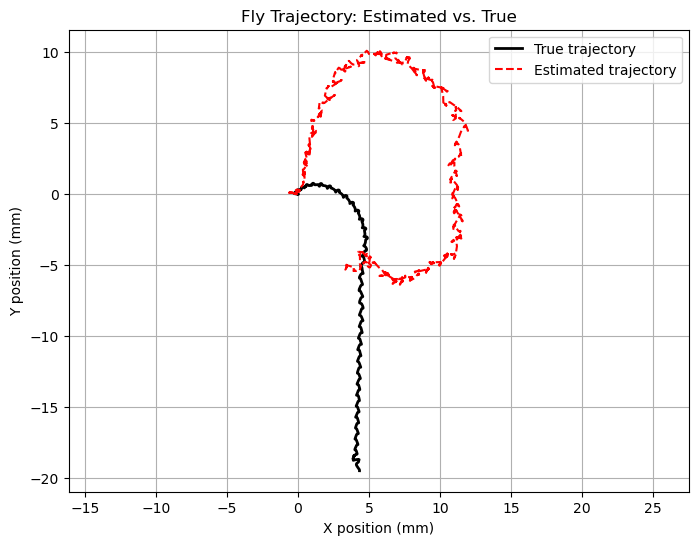

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Estimated trajectory
estimated = np.array(controller.position_trace)

# True trajectory: extract first row from obs["fly"] (x, y, z), keep only x and y
true_points = []
for obs in obs_hist:
    try:
        if "fly" in obs:
            pos = obs["fly"][0]  # First row: position
            if isinstance(pos, (list, tuple, np.ndarray)) and len(pos) >= 2:
                true_points.append([pos[0], pos[1]])
    except Exception:
        continue

true = np.array(true_points)

# Plot
plt.figure(figsize=(8, 6))
if len(true) > 0:
    plt.plot(true[:, 0], true[:, 1], label="True trajectory", color="black", linewidth=2)
if len(estimated) > 0:
    plt.plot(estimated[:, 0], estimated[:, 1], label="Estimated trajectory", color="red", linestyle="--", linewidth=1.5)






plt.xlabel("X position (mm)")
plt.ylabel("Y position (mm)")
plt.title("Fly Trajectory: Estimated vs. True")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


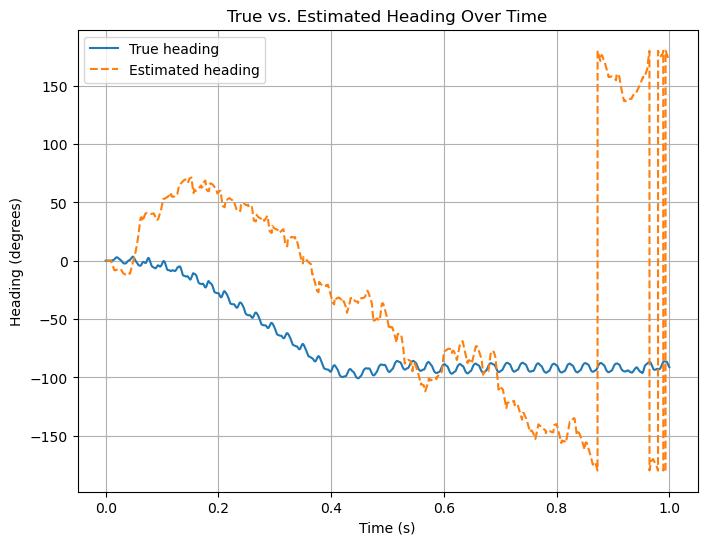

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've recorded headings in controller and observations
# E.g., in your test notebook:
#    controller.heading_trace.append(controller.heading)
#    obs_hist.append(obs)

estimated = np.rad2deg(np.array(controller.heading_trace))  # degrees
true     = np.rad2deg(np.array([obs["heading"] for obs in obs_hist]))  # degrees

# Generate a time axis
timestep = controller.timestep
time = np.arange(len(estimated)) * timestep

# Plot
plt.figure(figsize=(8, 6))
if len(true) > 0:
    plt.plot(time[:len(true)], true, label="True heading")
if len(estimated) > 0:
    plt.plot(time[:len(estimated)], estimated, label="Estimated heading", linestyle="--")

plt.xlabel("Time (s)")
plt.ylabel("Heading (degrees)")
plt.title("True vs. Estimated Heading Over Time")
plt.legend()
plt.grid(True)
plt.show()


[[0.00107505 0.00111839 0.00109252 0.00110494]
 [0.         0.         0.         0.        ]]


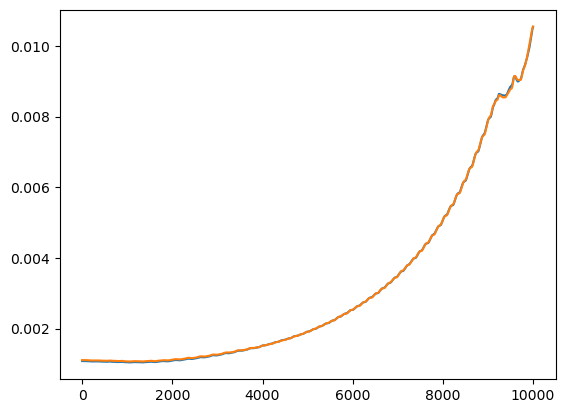

In [46]:
#plot of the odor intensity 
import matplotlib.pyplot as plt
import numpy as np

print(obs_hist[0]["odor_intensity"])    


     
odor_left = [((obs["odor_intensity"][0][0] + obs["odor_intensity"][0][2]))/2 for obs in obs_hist]
odor_right = [((obs["odor_intensity"][0][1] + obs["odor_intensity"][0][3]))/2 for obs in obs_hist]

plt.plot(odor_left, label="Left Odor Intensity")
plt.plot(odor_right, label="Right Odor Intensity")
